In [1]:
%matplotlib inline

In [2]:
"""
MY RED PID REMOTE

This program acquire date from the red pitaya after an initial trigger pulse and 
saves the results to the hard disc

written for python3
Created on Thu Apr 06 10:37:27 2017
@author: Gerhard Schunk
"""
import sys, os
import numpy as np
import pdb
import time as tm
from matplotlib.pyplot import cm 
from itertools import cycle
from itertools import cycle
import multiprocessing
import ctypes
import matplotlib.pyplot as plt

In [3]:
from redpid_lib import autocorr, smooth, tiltcorrect, read_user_input, get_error_max

In [4]:
import redpitaya_scpi as scpi
###REMOTE CONNECTION
rp_s = scpi.scpi("10.64.11.12")

In [5]:
###FOLDER SETTINGS
pathname = os.getcwd()
print(os.walk(pathname))
dir_list = [x[0] for x in os.walk(pathname)]
for dir_name in dir_list:
    if not(dir_name.find("plots")) == -1:
        plots_path = dir_name + dir_name[-6]
data_path = plots_path[:-7] + plots_path[-1] +  'data' + plots_path[-1] 


<generator object walk at 0x0617D558>


EOFError: 

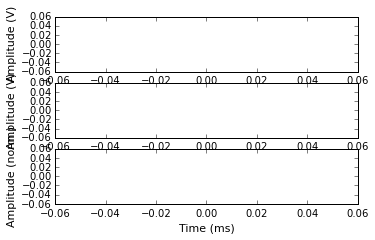

In [6]:
###PLOT SETTINGES
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal',
'verticalalignment':'bottom'} # Bottom vertical alignment for more space
#legend_font = {'family':'Times New Roman','size':'8'}
title_font = {'size':'11'}
axis_font = {'size':'11'}
ticks_font = {'size':'11'}
label_font = {'size':'11'}
legend_font = {'size':'8'}

plt.clf()
fig1 = plt.figure(1,tight_layout=True,figsize=(22.5/2.53, 10./2.53))

ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)

fig1.subplots_adjust(left=0.25)
fig1.subplots_adjust(bottom=0.25)
fig1.subplots_adjust(top=0.90)
fig1.subplots_adjust(right=0.95)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.)
    ax2.spines[axis].set_linewidth(1.)
    ax3.spines[axis].set_linewidth(1.)

plt_title = ax1.set_title(' ')

color=cycle(cm.rainbow(np.linspace(0,1,20)))

ax1_hdl, = ax1.plot([],[])
ax2_hdl, = ax2.plot([],[])
ax3_hdl, = ax3.plot([],[])

ax1.set_ylabel('Amplitude (V)',**axis_font)
ax2.set_ylabel('Amplitude (V)',**axis_font)
ax3.set_ylabel('Amplitude (norm.)',**axis_font)
ax3.set_xlabel('Time (ms)',**axis_font)

###START MAIN PROCESS
"includes plotting"
if __name__ == '__main__':

    ###THREADING SETTINGS
    datamanager = multiprocessing.Manager()
    datalist = datamanager.list()
    flag = multiprocessing.Value(ctypes.c_int, 0) #the flag is used to terminate the whole program, 0 is running
    pid_status = multiprocessing.Value(ctypes.c_int, 0) # PID is off for 0, on for 1
    P_pid = multiprocessing.Value(ctypes.c_int, 10) #the flag is used to terminate the whole program, 0 is running
    I_pid = multiprocessing.Value(ctypes.c_int, 0)
    I_pid_curr = 0 #Initial setting of I part of pid
    pid_output = 0 #the pid is starting from 0, but there is an pid offset of 50 percent to start in the middle
    pid_offset = 50. # start in the middle of the voltage setting

    ###DATA ACQUISION
    #best
    #decimation = int(2**6)
    #buff_len = 2**12 #2ms

    decimation = int(2**10)
    buff_len = 2**10 #2ms
    num_run = 4
    sample_rate_MHz = 125. / decimation
    delta_time_ms_ms = 1. / sample_rate_MHz * 10**(-3) 

#	print '###START RECORDING###'
#	print 'decimation is', decimation, 
#	print 'Nr of runs', num_run
#	print 'Nr of samples', buff_len
#	print 'sample_rate_MHz', sample_rate_MHz
#	print 'sampling distance_ms', delta_time_ms_ms

    ###START RECORDING
    rp_s.tx_txt('ACQ:RST')
    rp_s.tx_txt('ACQ:DEC '+str(decimation))
    rp_s.tx_txt('ACQ:TRIG:LEV 1')

    ini_time_ms = tm.time()
    ite_meas = 1
    for ite_meas in range(num_run):
    #while flag.value == 0:
    #if flag == 1:
    #break
        ite_meas =  1
        start_time_ms = tm.time()
        rp_s.tx_txt('ACQ:TRIG:DLY ' + str(int(buff_len-1000.)))
        rp_s.tx_txt('ACQ:START')
        tm.sleep(1.)	#pause to refresh buffer
        rp_s.tx_txt('ACQ:TRIG EXT_PE')


        while 1:
            rp_s.tx_txt('ACQ:TRIG:STAT?')
            rcv = 	rp_s.rx_txt() 
    #	    print rcv
            if rcv == 'TD':
                break

        ###READ TACE 1
    #	rp_s.tx_txt('ACQ:SOUR1:DATA?')
        rp_s.tx_txt('ACQ:SOUR1:DATA:OLD:N? ' + str(int(buff_len)))
        buff_string = rp_s.rx_txt()
        buff_string = buff_string.strip('{}\n\r').replace("  ", "").split(',')
        buff = list(map(float, buff_string))
        y_trace1_V = np.asarray(buff)
        time_trace1_ms = range(len(y_trace1_V))
        time_trace1_ms = np.asarray(time_trace1_ms) * delta_time_ms_ms


    #	while 1:
    #	    rp_s.tx_txt('ACQ:TRIG:STAT?')
    #	    rcv = 	rp_s.rx_txt() 
    ##	    print rcv
    #	    if rcv == 'TD':
    #	        break
    #	tm.sleep(.1)	#pause to refresh buffer

        ###READ TACE 2
    #	rp_s.tx_txt('ACQ:SOUR2:DATA?')
        rp_s.tx_txt('ACQ:SOUR2:DATA:OLD:N? ' + str(int(buff_len)))
        buff_string = rp_s.rx_txt()
        buff_string = buff_string.strip('{}\n\r').replace("  ", "").split(',')
        buff = list(map(float, buff_string))
        y_trace2_V = np.asarray(buff)
        time_trace2_ms = range(len(y_trace2_V))
        time_trace2_ms = np.asarray(time_trace2_ms) * delta_time_ms_ms

        ###PROCESS DATA
        smooth_pts = 100.
        time_trace1_ms = smooth(time_trace1_ms,smooth_pts)
        y_trace1_V = smooth(y_trace1_V,smooth_pts)
    #	y_trace1_V = tiltcorrect(y_trace1_V)
        y_trace1_V = y_trace1_V- np.min(y_trace1_V)
        y_trace1_V = np.abs(y_trace1_V)

        time_trace2_ms = smooth(time_trace2_ms,3)
        y_trace2_V = smooth(y_trace2_V,3)
        y_trace2_V = y_trace2_V- np.average(y_trace2_V)

        y_correllation = autocorr(y_trace1_V)
        time_correllation_ms = range(len(y_correllation))
        time_correllation_ms = np.asarray(time_correllation_ms) * delta_time_ms_ms
    #		print 'lengths: ', len(y_trace1_V), len(y_correllation)

        ###GET TIMING
        stop_time_ms = tm.time()
        rel_start_time = int(1000.*(start_time_ms - ini_time_ms))
        run_time_ms = int(1000.*(stop_time_ms - start_time_ms))
    #		print '\nNew trace:'
    #		print 'Relative start time', rel_start_time, ' ms'
    #		print 'run time', run_time_ms, ' ms'

        ###PLOT TRACES		
        if 1==1:
            plt.ion()		
            c=next(color)

            plt_title = ax1.set_title('measured after ' + str(rel_start_time) + ' ms',**title_font)

            ax1_hdl.remove()
            ax1_hdl, = ax1.plot(time_trace1_ms,y_trace1_V,markersize=5,linewidth = 1,color=c)
            ax1.set_xlim([0.,max(time_trace1_ms)])

            ax2_hdl.remove()
            ax2_hdl, = ax2.plot(time_trace2_ms,y_trace2_V,markersize=5,linewidth = 1,color=c)
            ax2.set_xlim([0.,max(time_trace2_ms)])

            ax3_hdl.remove()
            ax3_hdl, = ax3.plot(time_correllation_ms,y_correllation,markersize=5,linewidth = 1,color=c)
        #		ax3.set_xlim([0.,max(time_correllation_ms)])

            plt.draw()

        #SAVE DATA
        savename = str(ite_meas) + '_test'
        #	np.array(y_trace1_V).dump(open(data_path+'\\'+savename+'.npy', 'wb'))
        #myArray = np.load(open('array.npy', 'rb'))

        ###START PID
        ###READ USER INPUT
        newstdin = sys.stdin.fileno()
        reading_process = multiprocessing.Process(target=read_user_input, args=(newstdin,flag,pid_status,P_pid,I_pid))
        reading_process.start()
        #print('flag, pid_status, P, I ', flag.value, pid_status.value, P_pid.value, I_pid.value)
        #		newstdin = sys.stdin.fileno()
        #		read_user_input(newstdin)

        if pid_status.value == 0:
            ind_set = np.argmax(y_trace1_V)
        else:
            pid_error = get_error_max(y_trace1_V,ind_set,)
            pid_error = float(1.*pid_error/buff_len)

            ###CALCULATE PID OUTPUT
            P_pid_curr = P_pid.value * pid_error
            I_pid_curr = I_pid.value * pid_error + I_pid_curr
            pid_output = P_pid_curr + I_pid_curr

    ###DEFINE OUTPUT
    #rp_s.tx_txt('CR/LF'); #no idea what this one does
    pid_output_percent = pid_output + pid_offset

    if pid_output_percent < 0:
        pid_output_percent = 0
    if pid_output_percent > 100.:
        pid_output_percent = 100.

    #print 'pid_output_percent', pid_output_percent

    pid_output_V = str((1.8/100)*pid_output_percent)     #from 0 - 1.8 volts
    pin_out_num = '2'  #Analog outputs 0,1,2,3

    scpi_command = 'ANALOG:PIN AOUT' + pin_out_num + ',' + pid_output_V
    rp_s.tx_txt(scpi_command)

    av_time = int(1000.*(stop_time_ms-ini_time_ms ) / num_run)
    print('averaged run time is ', av_time, ' ms')
    ###LABELS AND LEGENDS

    #TICKS
    ax1.locator_params(axis = 'x', nbins = 6)
    ax1.locator_params(axis = 'y', nbins = 4)

    ###SAVE PLOTS
    filename = 'oszi_trace'
    fig1.canvas.draw()
    xlabels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(xlabels,**ticks_font)
    ylabels = [item.get_text() for item in ax1.get_yticklabels()]
    ax1.set_yticklabels(ylabels,**ticks_font)

    #fig1.savefig(plots_path + savename + '.pdf', transparent=True)
    fig1.savefig(plots_path + savename + '.png', dpi=300, transparent=True)

    plt.close()